In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from fbprophet import Prophet
import matplotlib.pyplot as plt
import math as math

%matplotlib inline

In [2]:
# Load the data
train = pd.read_csv("../input/train_1.csv").fillna(0)
keys = pd.read_csv("../input/key_1.csv").fillna(0)
ss = pd.read_csv("../input/sample_submission_1.csv").fillna(0)

In [3]:
train

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0
5,5566_zh.wikipedia.org_all-access_spider,12.0,7.0,4.0,5.0,20.0,8.0,5.0,17.0,24.0,...,16.0,27.0,8.0,17.0,32.0,19.0,23.0,17.0,17.0,50.0
6,91Days_zh.wikipedia.org_all-access_spider,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,7.0,33.0,8.0,11.0,4.0,15.0,6.0,8.0,6.0
7,A'N'D_zh.wikipedia.org_all-access_spider,118.0,26.0,30.0,24.0,29.0,127.0,53.0,37.0,20.0,...,64.0,35.0,35.0,28.0,20.0,23.0,32.0,39.0,32.0,17.0
8,AKB48_zh.wikipedia.org_all-access_spider,5.0,23.0,14.0,12.0,9.0,9.0,35.0,15.0,14.0,...,34.0,105.0,72.0,36.0,33.0,30.0,36.0,38.0,31.0,97.0
9,ASCII_zh.wikipedia.org_all-access_spider,6.0,3.0,5.0,12.0,6.0,5.0,4.0,13.0,9.0,...,25.0,17.0,22.0,29.0,30.0,29.0,35.0,44.0,26.0,41.0


In [4]:
def smape(predict, actual, debug=False):
    
    actual = actual.fillna(0)
    data = pd.concat([predict, actual], axis=1, keys=['predict', 'actual'])
    data = data[data.actual.notnull()]
    if debug:
        print('debug', data)
    
    evals = abs(data.predict - data.actual) * 1.0 / (abs(data.predict) + abs(data.actual)) * 2
    evals[evals.isnull()] = 0
    
    result = np.sum(evals) / len(data)
    
    return result

In [5]:
def plot_prediction_and_actual_2(train, forecast, actual, xlim=None, ylim=None, figSize=None, title=None):
    fig, ax  = plt.subplots(1,1,figsize=figSize)
    ax.plot(pd.to_datetime(train.index), train.values, 'k.')
    ax.plot(pd.to_datetime(actual.index), actual.values, 'r.')
    ax.plot(pd.to_datetime(forecast.index), forecast.values, 'b-')
    ax.set_title(title)
    plt.show()

In [6]:
page_details = train.Page.str.extract(r'(?P<topic>.*)\_(?P<lang>.*).wikipedia.org\_(?P<access>.*)\_(?P<type>.*)')

page_details[0:10]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.


,topic,lang,access,type
0,2NE1,zh,all-access,spider
1,2PM,zh,all-access,spider
2,3C,zh,all-access,spider
3,4minute,zh,all-access,spider
4,52_Hz_I_Love_You,zh,all-access,spider
5,5566,zh,all-access,spider
6,91Days,zh,all-access,spider
7,A'N'D,zh,all-access,spider
8,AKB48,zh,all-access,spider
9,ASCII,zh,all-access,spider


In [7]:
def extract_series(df, row_num, start_idx):
    y = df.iloc[row_num, start_idx:]
    df = pd.DataFrame({ 'ds': y.index, 'y': y.values})
    return df

In [8]:
# Generate train and validate dataset
train_df = pd.concat([page_details, train], axis=1)

def get_train_validate_set(train_df, test_percent):
    train_end = math.floor((train_df.shape[1]-5) * (1-test_percent))
    train_ds = train_df.iloc[:, np.r_[0,1,2,3,4,5:train_end]]
    test_ds = train_df.iloc[:, np.r_[0,1,2,3,4,train_end:train_df.shape[1]]]
    
    return train_ds, test_ds

X_train, y_train = get_train_validate_set(train_df, 0.1)

print("The training set sample:")
print(X_train[0:10])
print("The validation set sample:")
print(y_train[0:10])

The training set sample:
              topic lang      access    type  \
0              2NE1   zh  all-access  spider   
1               2PM   zh  all-access  spider   
2                3C   zh  all-access  spider   
3           4minute   zh  all-access  spider   
4  52_Hz_I_Love_You   zh  all-access  spider   
5              5566   zh  all-access  spider   
6            91Days   zh  all-access  spider   
7             A'N'D   zh  all-access  spider   
8             AKB48   zh  all-access  spider   
9             ASCII   zh  all-access  spider   

                                                Page  2015-07-01  2015-07-02  \
0            2NE1_zh.wikipedia.org_all-access_spider        18.0        11.0   
1             2PM_zh.wikipedia.org_all-access_spider        11.0        14.0   
2              3C_zh.wikipedia.org_all-access_spider         1.0         0.0   
3         4minute_zh.wikipedia.org_all-access_spider        35.0        13.0   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-acces

In [9]:
# holiday variable
#holiday_en = ['2015-01-01', '2015-01-19', '2015-04-03', '2015-05-04', '2015-05-25', '2015-07-01', '2015-07-03', '2015-09-07', '2015-11-26', '2015-11-27', '2015-12-25', '2015-12-26', '2015-12-28', '2016-01-01', '2016-01-18', '2016-03-25', '2016-05-02', '2016-05-30', '2016-07-01', '2016-07-04', '2016-09-05', '2016-11-11', '2016-11-24', '2016-12-25', '2016-12-26', '2016-12-27', '2017-01-01', '2017-01-02', '2017-01-16', '2017-04-14', '2017-05-01', '2017-05-29', '2017-07-01', '2017-07-03', '2017-07-04', '2017-09-04', '2017-11-10', '2017-11-23', '2017-12-25', '2017-12-26']

holiday_en_us = ['2015-01-01', '2015-01-19', '2015-05-25', '2015-07-03', '2015-09-07', '2015-11-26', '2015-11-27', '2015-12-25', '2016-01-01', '2016-01-18', '2016-05-30', '2016-07-04', '2016-09-05', '2016-11-11', '2016-11-24', '2016-12-26', '2017-01-01', '2017-01-02', '2017-01-16', '2017-05-29', '2017-07-04', '2017-09-04', '2017-11-10', '2017-11-23', '2017-12-25']
holiday_en_uk = ['2015-01-01', '2015-04-03', '2015-05-04', '2015-05-25', '2015-12-25', '2015-12-26', '2015-12-28', '2016-01-01', '2016-03-25', '2016-05-02', '2016-05-30', '2016-12-26', '2016-12-27', '2017-01-01', '2017-04-14', '2017-05-01', '2017-05-29', '2017-12-25', '2017-12-26']
holiday_en_canada = ['2015-01-01', '2015-07-01', '2015-09-07', '2015-12-25', '2016-01-01', '2016-07-01', '2016-09-05', '2016-12-25', '2017-01-01', '2017-07-01', '2017-07-03', '2017-09-04', '2017-12-25']

holiday_ru_russia = ['2015-01-01', '2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08', '2015-01-09', '2015-02-23', '2015-03-09', '2015-05-01', '2015-05-04', '2015-05-09', '2015-05-11', '2015-06-12', '2015-11-04', '2016-01-01', '2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07', '2016-02-22', '2016-02-23', '2016-03-08', '2016-05-01', '2016-05-09', '2016-06-12', '2016-06-13', '2016-11-04', '2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06', '2017-01-07', '2017-02-23', '2017-02-24', '2017-03-08', '2017-05-01', '2017-05-08', '2017-05-09', '2017-06-12', '2017-11-04', '2017-11-06']
#holiday_es = ['2015-01-01', '2015-01-06', '2015-01-12', '2015-02-02', '2015-03-16', '2015-03-23', '2015-04-02', '2015-04-03', '2015-05-01', '2015-05-18', '2015-06-08', '2015-06-15', '2015-06-29', '2015-07-20', '2015-08-07', '2015-08-17', '2015-09-16', '2015-10-12', '2015-11-01', '2015-11-02', '2015-11-16', '2015-12-06', '2015-12-08', '2015-12-12', '2015-12-25', '2016-01-01', '2016-01-06', '2016-01-11', '2016-02-01', '2016-03-21', '2016-03-24', '2016-03-25', '2016-05-01', '2016-05-09', '2016-05-30', '2016-06-06', '2016-07-04', '2016-07-20', '2016-08-07', '2016-08-15', '2016-09-16', '2016-10-12', '2016-10-17', '2016-11-01', '2016-11-02', '2016-11-07', '2016-11-14', '2016-11-21', '2016-12-06', '2016-12-08', '2016-12-12', '2016-12-25', '2016-12-26', '2017-01-01', '2017-01-02', '2017-01-06', '2017-01-09', '2017-02-06', '2017-03-20', '2017-04-13', '2017-04-14', '2017-05-01', '2017-05-29', '2017-06-19', '2017-06-26', '2017-07-03', '2017-07-20', '2017-08-07', '2017-08-15', '2017-09-16', '2017-10-12', '2017-10-16', '2017-11-01', '2017-11-02', '2017-11-06', '2017-11-13', '2017-11-20', '2017-12-06', '2017-12-08', '2017-12-12', '2017-12-25']

holiday_es_mexico = ['2015-01-01', '2015-02-02', '2015-03-16', '2015-04-02', '2015-04-03', '2015-05-01', '2015-09-16', '2015-10-12', '2015-11-02', '2015-11-16', '2015-12-12', '2015-12-25', '2016-01-01', '2016-02-01', '2016-03-21', '2016-03-24', '2016-03-25', '2016-05-01', '2016-09-16', '2016-10-12', '2016-11-02', '2016-11-21', '2016-12-12', '2016-12-25', '2016-12-26', '2017-01-01', '2017-01-02', '2017-02-06', '2017-03-20', '2017-04-13', '2017-04-14', '2017-05-01', '2017-09-16', '2017-10-12', '2017-11-02', '2017-11-20', '2017-12-12', '2017-12-25']
holiday_es_spain = ['2017-01-01', '2017-01-06', '2017-04-14', '2017-05-01', '2017-08-15', '2017-10-12', '2017-11-01', '2017-12-06', '2017-12-08', '2017-12-25', '2016-01-01', '2016-01-06', '2016-03-25', '2016-05-01', '2016-08-15', '2016-10-12', '2016-11-01', '2016-12-06', '2016-12-08', '2016-12-25', '2015-01-01', '2015-01-06', '2015-04-03', '2015-05-01', '2015-10-12', '2015-11-01', '2015-12-06', '2015-12-08', '2015-12-25']
holiday_es_colombia = ['2015-01-01', '2015-01-12', '2015-03-23', '2015-04-02', '2015-04-03', '2015-05-01', '2015-05-18', '2015-06-08', '2015-06-15', '2015-06-29', '2015-07-20', '2015-08-07', '2015-08-17', '2015-10-12', '2015-11-02', '2015-11-16', '2015-12-08', '2015-12-25', '2016-01-01', '2016-01-11', '2016-03-21', '2016-03-24', '2016-03-25', '2016-05-01', '2016-05-09', '2016-05-30', '2016-06-06', '2016-07-04', '2016-07-20', '2016-08-07', '2016-08-15', '2016-10-17', '2016-11-07', '2016-11-14', '2016-12-08', '2016-12-25', '2017-01-01', '2017-01-09', '2017-03-20', '2017-04-13', '2017-04-14', '2017-05-01', '2017-05-29', '2017-06-19', '2017-06-26', '2017-07-03', '2017-07-20', '2017-08-07', '2017-08-15', '2017-10-16', '2017-11-06', '2017-11-13', '2017-12-08', '2017-12-25']

holiday_fr_france = ['2015-01-01', '2015-04-06', '2015-05-01', '2015-05-08', '2015-05-14', '2015-05-25', '2015-07-14', '2015-08-15', '2015-11-01', '2015-11-11', '2015-12-25', '2016-01-01', '2016-03-28', '2016-05-01', '2016-05-05', '2016-05-08', '2016-05-16', '2016-07-14', '2016-08-15', '2016-11-01', '2016-11-11', '2016-12-25', '2017-01-01', '2017-04-17', '2017-05-01', '2017-05-08', '2017-05-25', '2017-06-05', '2017-07-14', '2017-08-15', '2017-11-01', '2017-11-11', '2017-12-25']
holiday_jp_japan = ['2015-01-01', '2015-01-12', '2015-02-11', '2015-03-21', '2015-04-29', '2015-05-03', '2015-05-04', '2015-05-05', '2015-05-06', '2015-07-20', '2015-09-21', '2015-09-22', '2015-09-23', '2015-10-12', '2015-11-03', '2015-11-23', '2015-12-23', '2016-01-01', '2016-01-11', '2016-02-11', '2016-03-21', '2016-04-29', '2016-05-03', '2016-05-04', '2016-05-05', '2016-07-18', '2016-08-11', '2016-09-19', '2016-09-22', '2016-10-10', '2016-11-03', '2016-11-23', '2016-12-23', '2017-01-01', '2017-01-09', '2017-02-11', '2017-03-20', '2017-04-29', '2017-05-03', '2017-05-04', '2017-05-05', '2017-07-17', '2017-08-11', '2017-09-18', '2017-09-22', '2017-10-09', '2017-11-03', '2017-11-23', '2017-12-23']

#holiday_de = ['2015-01-01', '2015-01-06', '2015-04-03', '2015-04-06', '2015-05-01', '2015-05-14', '2015-05-25', '2015-06-04', '2015-08-01', '2015-08-15', '2015-10-03', '2015-10-26', '2015-11-01', '2015-12-08', '2015-12-25', '2015-12-26', '2016-01-01', '2016-01-06', '2016-03-25', '2016-03-28', '2016-05-01', '2016-05-05', '2016-05-16', '2016-05-26', '2016-08-01', '2016-08-15', '2016-10-03', '2016-10-26', '2016-11-01', '2016-12-08', '2016-12-25', '2016-12-26', '2017-01-01', '2017-01-06', '2017-04-14', '2017-04-17', '2017-05-01', '2017-05-25', '2017-06-05', '2017-06-15', '2017-08-01', '2017-08-15', '2017-10-03', '2017-10-26', '2017-10-31', '2017-11-01', '2017-12-08', '2017-12-25', '2017-12-26']

holiday_de_germany = ['2015-01-01', '2015-04-03', '2015-04-06', '2015-05-01', '2015-05-14', '2015-05-14', '2015-05-25', '2015-10-03', '2015-12-25', '2015-12-26', '2016-01-01', '2016-03-25', '2016-03-28', '2016-05-01', '2016-05-05', '2016-05-16', '2016-10-03', '2016-12-25', '2016-12-26', '2017-01-01', '2017-04-14', '2017-04-17', '2017-05-01', '2017-05-25', '2017-06-05', '2017-10-03', '2017-10-31', '2017-12-25', '2017-12-26']
holiday_de_austria = ['2015-01-01', '2015-01-06', '2015-04-06', '2015-05-01', '2015-05-14', '2015-05-25', '2015-06-04', '2015-08-15', '2015-10-26', '2015-11-01', '2015-12-08', '2015-12-25', '2015-12-26', '2016-01-01', '2016-01-06', '2016-03-28', '2016-05-01', '2016-05-05', '2016-05-16', '2016-05-26', '2016-08-15', '2016-10-26', '2016-11-01', '2016-12-08', '2016-12-25', '2016-12-26', '2017-01-01', '2017-01-06', '2017-04-17', '2017-05-01', '2017-05-25', '2017-06-05', '2017-06-15', '2017-08-15', '2017-10-26', '2017-11-01', '2017-12-08', '2017-12-25', '2017-12-26']
holiday_de_switzerland = ['2015-01-01', '2015-04-03', '2015-05-14', '2015-08-01', '2015-12-25', '2016-01-01', '2016-03-25', '2016-05-05', '2016-08-01', '2016-12-25', '2017-01-01', '2017-04-14', '2017-05-25', '2017-08-01', '2017-12-25']

#holiday_zh = ['2015-01-01', '2015-02-18', '2015-02-19', '2015-02-20', '2015-02-21', '2015-02-22', '2015-02-23', '2015-02-27', '2015-04-03', '2015-04-04', '2015-04-05', '2015-04-06', '2015-04-07', '2015-05-01', '2015-05-25', '2015-06-19', '2015-06-20', '2015-07-01', '2015-09-03', '2015-09-28', '2015-10-01', '2015-10-09', '2015-10-10', '2015-10-21', '2015-12-25', '2015-12-26', '2016-01-01', '2016-02-07', '2016-02-08', '2016-02-09', '2016-02-10', '2016-02-11', '2016-02-12', '2016-02-29', '2016-03-25', '2016-03-26', '2016-03-28', '2016-04-04', '2016-04-05', '2016-05-01', '2016-05-02', '2016-05-14', '2016-06-09', '2016-06-10', '2016-07-01', '2016-09-15', '2016-09-16', '2016-09-28', '2016-10-01', '2016-10-10', '2016-12-25', '2016-12-26', '2016-12-27', '2017-01-01', '2017-01-02', '2017-01-27', '2017-01-28', '2017-01-29', '2017-01-30', '2017-01-31', '2017-02-01', '2017-02-27', '2017-02-28', '2017-04-03', '2017-04-04', '2017-04-14', '2017-04-15', '2017-04-17', '2017-05-01', '2017-05-03', '2017-05-29', '2017-05-30', '2017-07-01', '2017-10-01', '2017-10-02', '2017-10-04', '2017-10-05', '2017-10-09', '2017-10-10', '2017-10-28', '2017-12-25', '2017-12-26']

holiday_zh_hongkong = ['2015-01-01', '2015-02-19', '2015-02-20', '2015-04-03', '2015-04-04', '2015-04-05', '2015-04-06', '2015-04-07', '2015-05-01', '2015-05-25', '2015-06-20', '2015-07-01', '2015-09-03', '2015-09-28', '2015-10-01', '2015-10-21', '2015-12-25', '2015-12-26', '2016-01-01', '2016-02-08', '2016-02-09', '2016-02-10', '2016-03-25', '2016-03-26', '2016-03-28', '2016-04-04', '2016-05-01', '2016-05-02', '2016-05-14', '2016-06-09', '2016-07-01', '2016-09-16', '2016-10-01', '2016-10-10', '2016-12-25', '2016-12-26', '2016-12-27', '2017-01-01', '2017-01-02', '2017-01-28', '2017-01-30', '2017-01-31', '2017-04-04', '2017-04-14', '2017-04-15', '2017-04-17', '2017-05-01', '2017-05-03', '2017-05-30', '2017-07-01', '2017-10-01', '2017-10-02', '2017-10-05', '2017-10-28', '2017-12-25', '2017-12-26']
holiday_zh_taiwan = ['2015-01-01', '2015-02-18', '2015-02-19', '2015-02-20', '2015-02-21', '2015-02-22', '2015-02-23', '2015-02-23', '2015-02-27', '2015-04-03', '2015-04-05', '2015-04-06', '2015-06-19', '2015-06-20', '2015-09-28', '2015-10-09', '2015-10-10', '2016-01-01', '2016-02-07', '2016-02-08', '2016-02-09', '2016-02-10', '2016-02-11', '2016-02-12', '2016-02-29', '2016-04-04', '2016-04-05', '2016-06-09', '2016-06-10', '2016-09-15', '2016-09-16', '2016-09-28', '2016-10-10', '2017-01-01', '2017-01-02', '2017-01-27', '2017-01-28', '2017-01-29', '2017-01-30', '2017-01-31', '2017-02-01', '2017-02-27', '2017-02-28', '2017-04-03', '2017-04-04', '2017-05-01', '2017-05-29', '2017-05-30', '2017-10-04', '2017-10-09', '2017-10-10']

holidays_en_us = pd.DataFrame({
  'holiday': 'US public holiday',
  'ds': pd.to_datetime(holiday_en_us),
  'lower_window': 0,
  'upper_window': 0,
})

holidays_en_uk = pd.DataFrame({
  'holiday': 'UK public holiday',
  'ds': pd.to_datetime(holiday_en_uk),
  'lower_window': 0,
  'upper_window': 0,
})

holidays_en_canada = pd.DataFrame({
  'holiday': 'Canada public holiday',
  'ds': pd.to_datetime(holiday_en_canada),
  'lower_window': 0,
  'upper_window': 0,
})

holidays_en = pd.concat((holidays_en_us, holidays_en_uk, holidays_en_canada))

holidays_ru_russia = pd.DataFrame({
  'holiday': 'Russia public holiday',
  'ds': pd.to_datetime(holiday_ru_russia),
  'lower_window': 0,
  'upper_window': 0,
})

holidays_ru = holidays_ru_russia

holidays_es_mexico = pd.DataFrame({
  'holiday': 'Mexico public holiday',
  'ds': pd.to_datetime(holiday_es_mexico),
  'lower_window': 0,
  'upper_window': 0,
})

holidays_es_spain = pd.DataFrame({
  'holiday': 'Spain public holiday',
  'ds': pd.to_datetime(holiday_es_spain),
  'lower_window': 0,
  'upper_window': 0,
})

holidays_es_colombia = pd.DataFrame({
  'holiday': 'Colombia public holiday',
  'ds': pd.to_datetime(holiday_es_colombia),
  'lower_window': 0,
  'upper_window': 0,
})

holidays_es = pd.concat((holidays_es_mexico, holidays_es_spain, holidays_es_colombia))

holidays_fr_france = pd.DataFrame({
  'holiday': 'France public holiday',
  'ds': pd.to_datetime(holiday_fr_france),
  'lower_window': 0,
  'upper_window': 0,
})

holidays_fr = holidays_fr_france

holidays_jp_japan = pd.DataFrame({
  'holiday': 'Japan public holiday',
  'ds': pd.to_datetime(holiday_jp_japan),
  'lower_window': 0,
  'upper_window': 0,
})

holidays_jp = holidays_jp_japan

holidays_de_germany = pd.DataFrame({
  'holiday': 'Germany public holiday',
  'ds': pd.to_datetime(holiday_de_germany),
  'lower_window': 0,
  'upper_window': 0,
})

holidays_de_austria = pd.DataFrame({
  'holiday': 'Austria public holiday',
  'ds': pd.to_datetime(holiday_de_austria),
  'lower_window': 0,
  'upper_window': 0,
})

holidays_de_switzerland = pd.DataFrame({
  'holiday': 'Switzerland public holiday',
  'ds': pd.to_datetime(holiday_de_switzerland),
  'lower_window': 0,
  'upper_window': 0,
})

holidays_de = pd.concat((holidays_de_germany, holidays_de_austria, holidays_de_switzerland))

holidays_zh_hongkong = pd.DataFrame({
  'holiday': 'HK public holiday',
  'ds': pd.to_datetime(holiday_zh_hongkong),
  'lower_window': 0,
  'upper_window': 0,
})

holidays_zh_taiwan = pd.DataFrame({
  'holiday': 'Taiwan public holiday',
  'ds': pd.to_datetime(holiday_zh_taiwan),
  'lower_window': 0,
  'upper_window': 0,
})

holidays_zh = pd.concat((holidays_zh_hongkong, holidays_zh_taiwan))

holidays_dict = {"en": holidays_en, 
                 "ru": holidays_ru, 
                 "es": holidays_es, 
                 "fr": holidays_fr, 
                 "ja": holidays_jp,
                 "de": holidays_de,
                 "zh": holidays_zh}

In [10]:
def median_holiday_model(df_train, df_actual, p, lang, review=False, figSize=(12, 4)):
    # Split the train and actual set
    
        
    df_train['ds'] = pd.to_datetime(df_train['ds'])
    df_actual['ds'] = pd.to_datetime(df_actual['ds'])
    train_series = df_train['y']
    train_series.index = df_train.ds
    
    if(isinstance(lang, float) and math.isnan(lang)):
        df_train['holiday'] = df_train.ds.dt.dayofweek >=5
        df_actual['holiday'] = df_actual.ds.dt.dayofweek >=5
    else:
        df_train['holiday'] = (df_train.ds.dt.dayofweek >=5) | df_train.ds.isin(holidays_dict[lang].ds)
        df_actual['holiday'] = (df_actual.ds.dt.dayofweek >=5) | df_actual.ds.isin(holidays_dict[lang].ds)
     
    # Combine the train and actual set
    predict_holiday = median_holiday_helper(df_train, df_actual[df_actual.holiday], p, True)
    predict_non_holiday = median_holiday_helper(df_train, df_actual[~df_actual.holiday], p, False)

    forecast_series = predict_non_holiday.combine_first(predict_holiday)
    
    actual_series = df_actual.y
    actual_series.index = df_actual.ds
    
    if(review):
        plot_prediction_and_actual_2(train_series, forecast_series, actual_series, figSize=figSize, title='Median model with holiday')
    
    return smape(forecast_series, actual_series)


def median_holiday_helper(df_train, df_actual, p, holiday):
    def nanmedian_zero(a):
        return np.nan_to_num(np.nanmedian(a))
    
    df_train['y'] = pd.to_numeric(df_train['y'])
    df_actual['y'] = pd.to_numeric(df_actual['y'])
    
    sample = df_train[-p:]
    if(holiday):
        sample = sample[sample['holiday']]
    else:
        sample = sample[~sample['holiday']]

    visits = nanmedian_zero(sample['y'])
    
    idx = np.arange( p) + np.arange(len(df_train)- p+1)[:,None]
    b = [row[row>=0] for row in df_train.y.values[idx]]
    pre_forecast = pd.Series(np.append(([float('nan')] * (p-1)), list(map(nanmedian_zero,b))))
    pre_forecast.index = df_train.ds
    
    forecast_series = pd.Series(np.repeat(visits, len(df_actual)))
    forecast_series.index = df_actual.ds
    
    forecast_series = pre_forecast.append(forecast_series)
    
    return forecast_series

                                    Page  2015-07-01  2015-07-02  2015-07-03  \
2  3C_zh.wikipedia.org_all-access_spider         1.0         0.0         1.0   

   2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  2015-07-09  \
2         1.0         0.0         4.0         0.0         3.0         4.0   

      ...      2016-12-22  2016-12-23  2016-12-24  2016-12-25  2016-12-26  \
2     ...             3.0         1.0         1.0         7.0         4.0   

   2016-12-27  2016-12-28  2016-12-29  2016-12-30  2016-12-31  
2         4.0         6.0         3.0         4.0        17.0  

[1 rows x 551 columns]


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


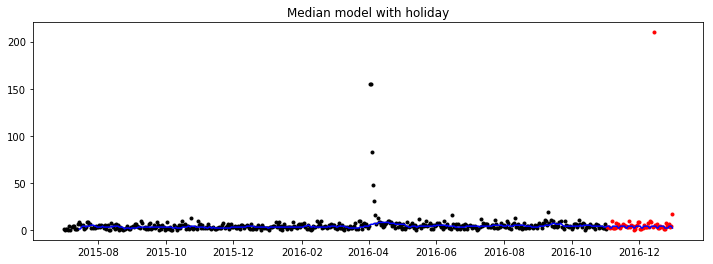

The SMAPE score is : 0.53178


In [11]:
# This is to demo the median model - weekday, weekend and 
print(train.iloc[[2]])

df_train = extract_series(X_train, 2, 5)
df_actual = extract_series(y_train, 2, 5)
lang = X_train.iloc[2, 1]
score = median_holiday_model(df_train.copy(), df_actual.copy(), 15, lang, review=True)
print("The SMAPE score is : %.5f" % score)